In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Project: Image classification using CNNs in Keras**
 
Dimitris Zografos


## **Introduction**<br>
Data Description:<br>
There is provided a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo.<br>
Dataset:<br>
The dataset was download from Olympus to Google Colab.<br>
The data file names are:<br>
 images.npy
 Label.csv

Learning Outcomes:<br>
 Pre-processing of image data.<br>
 Visualization of images.<br>
 Building CNN.<br>
 Evaluate the Model.<br>


### Import the libraries, load dataset, print shape of data, visualize the images in dataset

In [2]:
#importing all the necessary modules:
import cv2  # IMAGE PROCESSING - OPENCV
import math # MATHEMATICAL OPERATIONS
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
%matplotlib inline
from glob import glob # FILE OPERATIONS
import seaborn as sns
import cv2
import os
import itertools
import tensorflow as tf

from google.colab.patches import cv2_imshow
from tqdm import tqdm

# SKLEARN MODULES
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



# KERAS MODULES
from keras.utils.np_utils import to_categorical  #convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau


### **Load the data**

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
data = np.load('/content/drive/My Drive/Plants/plant-seedlings-classification/images.npy')

In [4]:
data

array([[[[ 35,  52,  78],
         [ 36,  49,  76],
         [ 31,  45,  69],
         ...,
         [ 78,  95, 114],
         [ 76,  93, 110],
         [ 80,  95, 109]],

        [[ 33,  46,  68],
         [ 37,  50,  73],
         [ 48,  65,  83],
         ...,
         [ 81,  96, 113],
         [ 74,  89, 105],
         [ 83,  95, 109]],

        [[ 34,  50,  68],
         [ 35,  52,  72],
         [ 70,  85, 101],
         ...,
         [ 83,  97, 112],
         [ 79,  94, 108],
         [ 79,  94, 107]],

        ...,

        [[ 35,  50,  69],
         [ 42,  57,  73],
         [ 42,  57,  72],
         ...,
         [ 60,  76,  92],
         [ 67,  81,  97],
         [ 64,  77,  95]],

        [[ 36,  52,  67],
         [ 48,  63,  78],
         [ 41,  57,  73],
         ...,
         [ 44,  66,  83],
         [ 58,  76,  91],
         [ 57,  74,  90]],

        [[ 44,  58,  70],
         [ 43,  57,  73],
         [ 40,  55,  72],
         ...,
         [ 41,  70,  92],
        

In [5]:
print("Shape of Images:", data.shape)

Shape of Images: (4750, 128, 128, 3)


In [6]:
data1 = pd.read_csv('/content/drive/My Drive/Plants/plant-seedlings-classification/Labels.csv')

In [7]:
print("Shape of Labels:", data1.shape)

Shape of Labels: (4750, 1)


In [8]:
base_path='/content/drive/My Drive/Plants'
save_extracted='/content/drive/My Drive/Plants/Save/'

In [9]:
np.save(save_extracted+'labels.npy', data1)

In [10]:
np.save(save_extracted+'images.npy', data)

In [11]:
TrainImages=np.load(save_extracted+'images.npy', False, True)
TrainLabels=np.load(save_extracted+'labels.npy', False, True)

In [12]:
print(f"Training image array shape:{TrainImages.shape}")
print(f"Training target labels:{TrainLabels.shape}")

Training image array shape:(4750, 128, 128, 3)
Training target labels:(4750, 1)


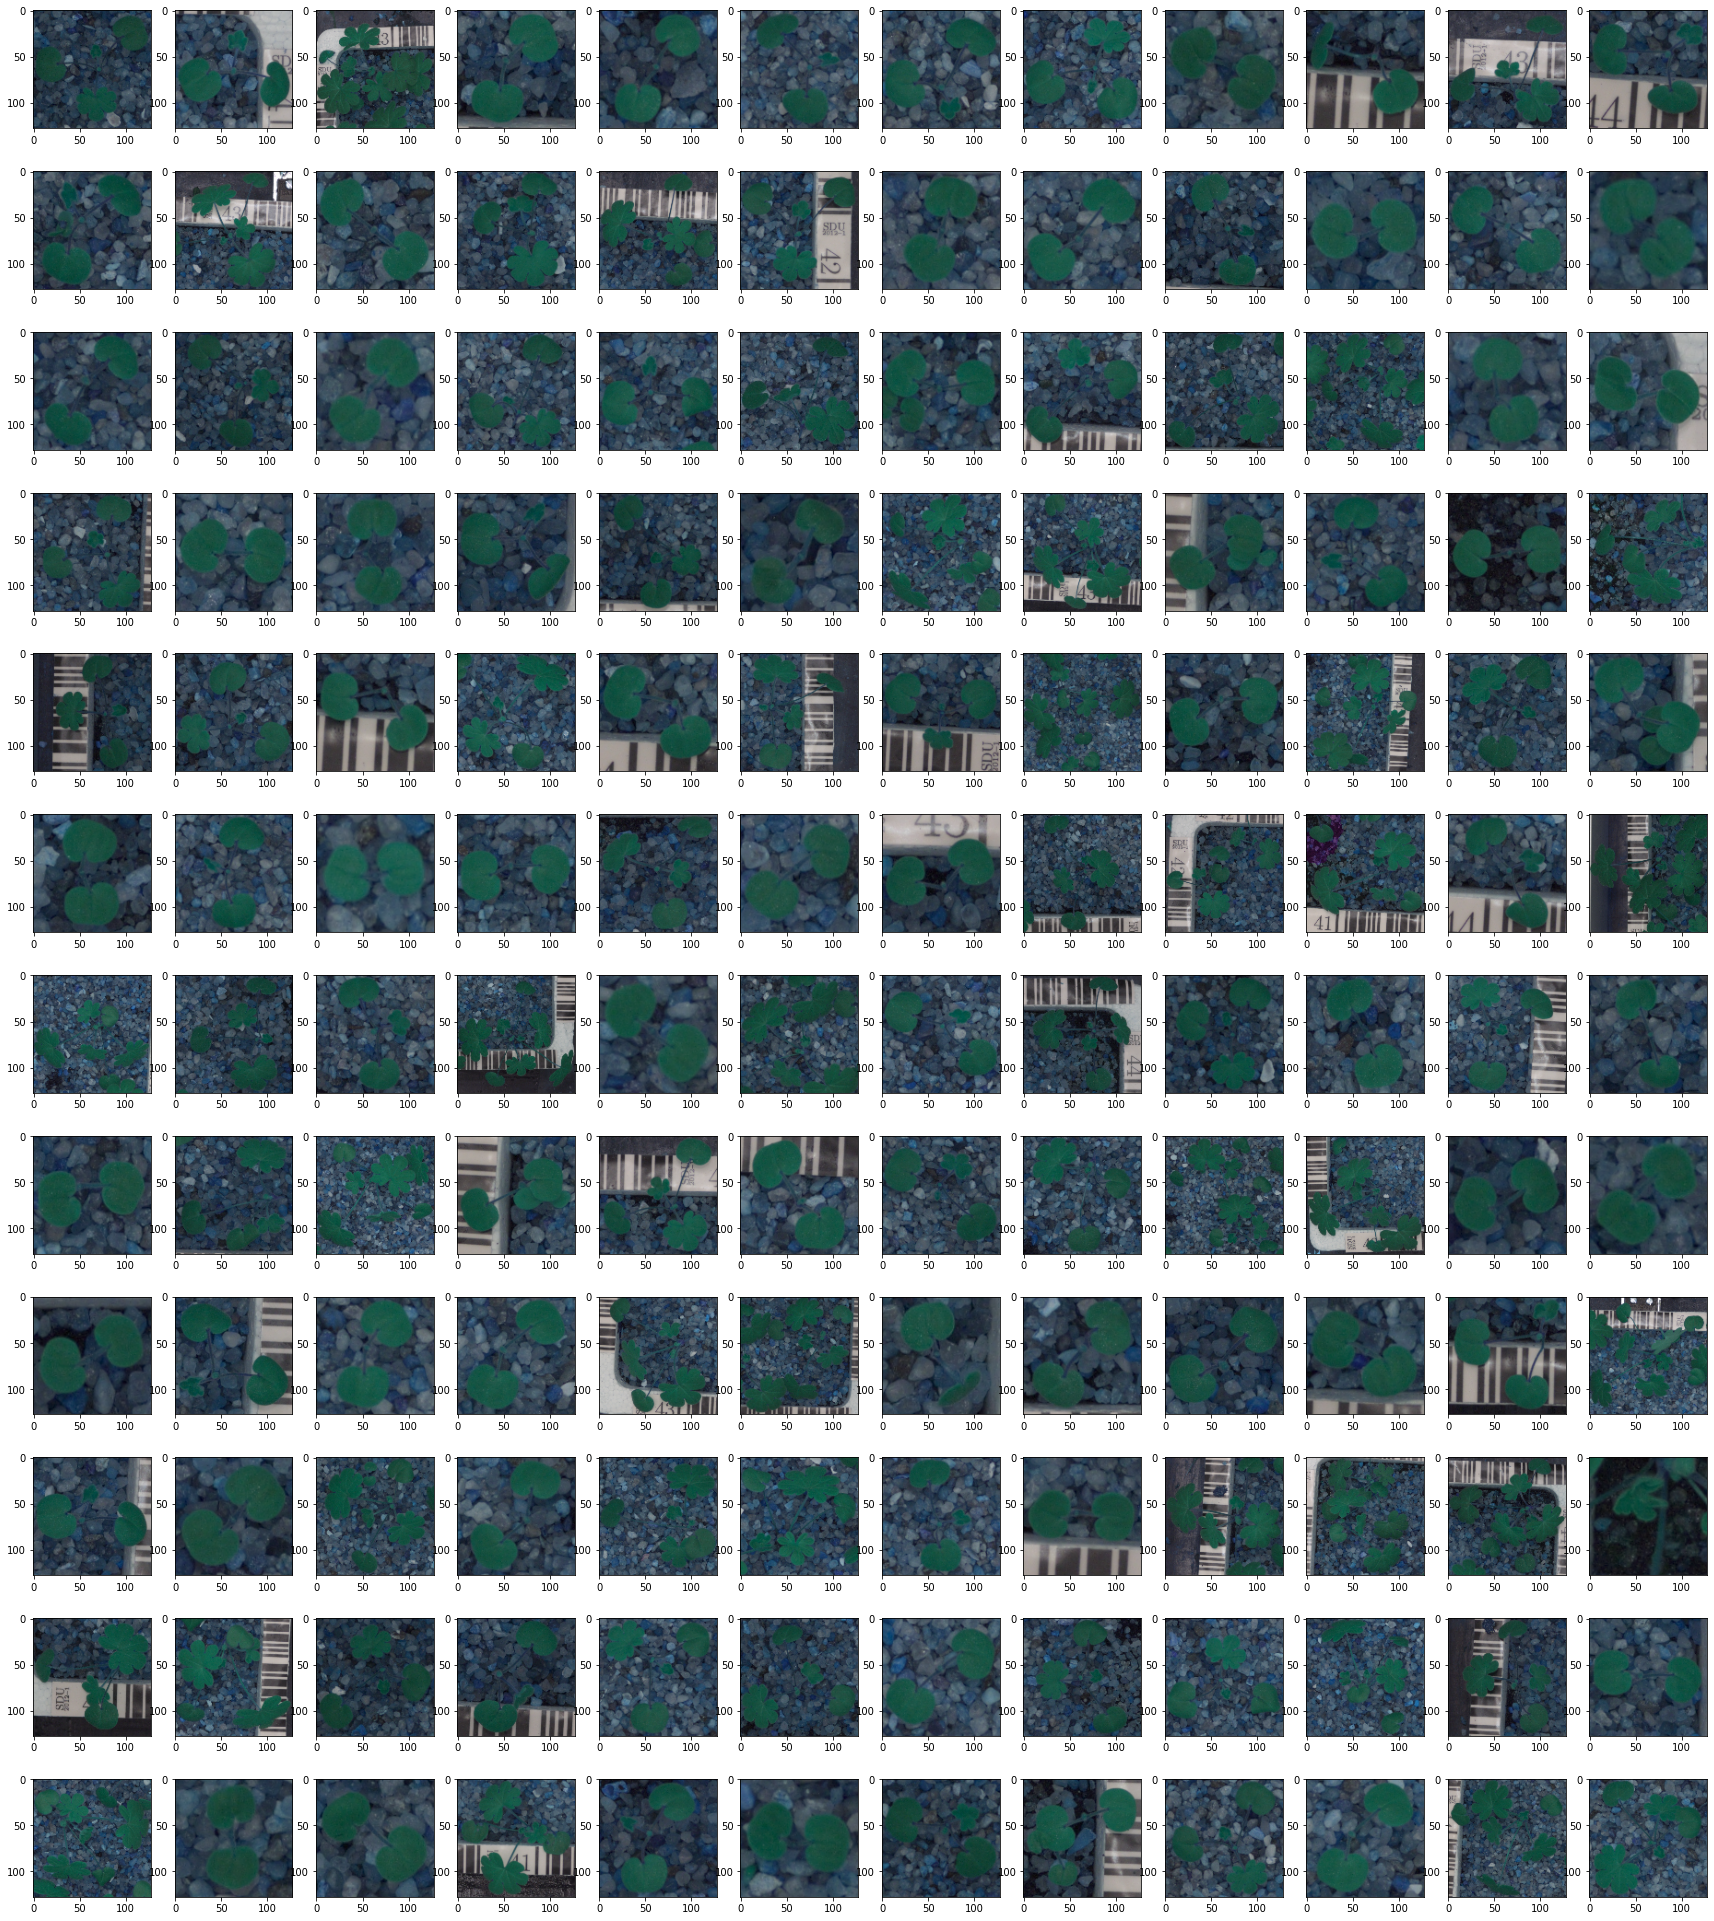

In [54]:
# visualize the images in dataset
fig=plt.figure(figsize=(30, 35))
columns = 12
rows = 12
for i in range(1, columns*rows +1):
    img = TrainImages[i]
    label = TrainLabels[i][0]
    #print(f'Image name:{label}')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show(block=True)

Image name:Small-flowered Cranesbill


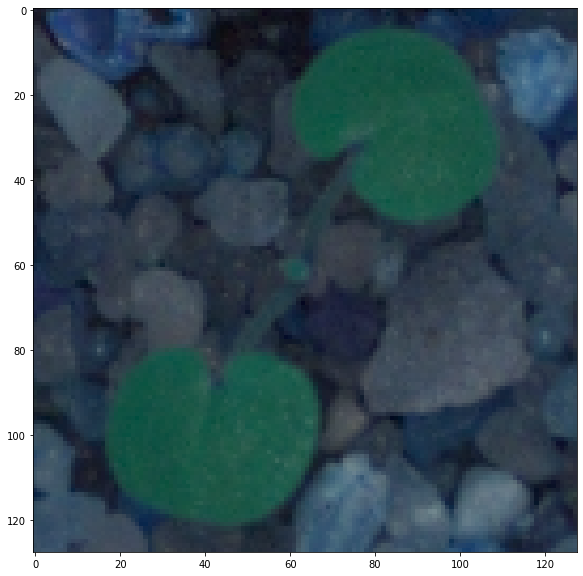

In [57]:
# Check Images and labels by choosing each time the value of i
fig=plt.figure(figsize=(10, 10))

i = 5
img = TrainImages[i]
label = TrainLabels[i][0]
print(f'Image name:{label}')
plt.imshow(img)


plt.show(block=True)

Few training image has less quality, but it might overcome in pre-processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


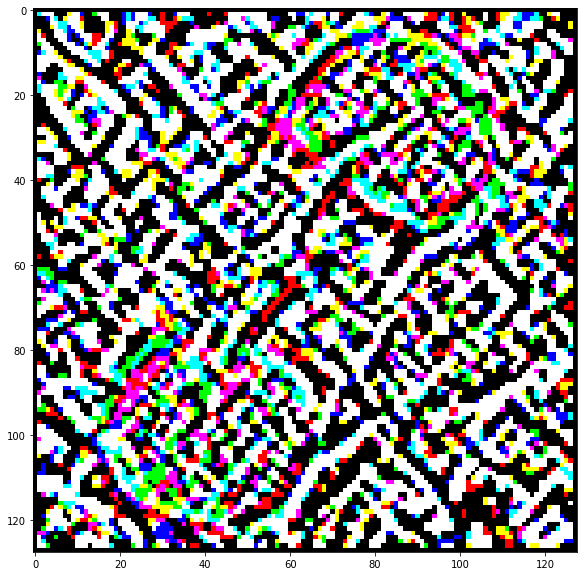

In [59]:
# Aply Sobel filter to justify image quality
fig=plt.figure(figsize=(10, 10))
sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(sobel)

## **Pre-processing**

**Normalize the Data**
*   The Data (TrainImages) needs to be normalized to 0-1 by 
diving the values by 255



In [60]:
TrainImages = TrainImages.astype('float32')
TrainImages /= 255
# Check the nomalized data
print(f'Shape of the Train array:{TrainImages.shape}')
print(f'Minimum value in the Train Array:{TrainImages.min()}')
print(f'Maximum value in the Train Array:{TrainImages.max()}')

Shape of the Train array:(4750, 128, 128, 3)
Minimum value in the Train Array:0.0
Maximum value in the Train Array:1.0


# **Split the dataset**

Split the dataset into training, testing, and validation set. (Hint: First split train images and train labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5)

In [61]:
# Step#1: Split train and test set
X_train, X_test, y_train, y_test = train_test_split(TrainImages, TrainLabels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((3325, 128, 128, 3), (1425, 128, 128, 3))

In [62]:
# Step#2: Split validation from test set
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_test.shape, X_validation.shape

((712, 128, 128, 3), (713, 128, 128, 3))

## **One Hot encoding to target values**

In [63]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_validation = encoder.fit_transform(y_validation)

There is an alternate way to convert the target variable to one-hot
1.   Convert String categorical to numeric
2.   Use tensorflow.keras.utils.to_categorical to convert to binary array




In [64]:
# Display target variable
y_train[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Gaussian Blurring**:
*Image blurring is achieved by convolving the image with a low-pass filter kernel. It is useful for removing noise. It actually removes high frequency content (e.g: noise, edges) from the image resulting in edges being blurred when this is filter is applied.*

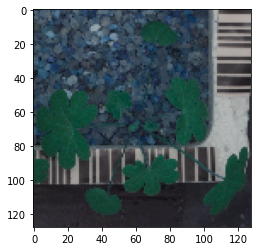

In [66]:
# Preview the image before Gaussian Blur
plt.imshow(X_train[10], cmap='gray')

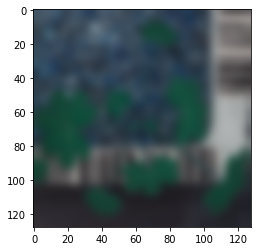

In [67]:
plt.imshow(cv2.GaussianBlur(X_train[10], (15,15), 0))

In [68]:
# Now we apply the gaussian blur to each 128x128 pixels array (image) to reduce the noise in the image
for idx, img in enumerate(X_train):
  X_train[idx] = cv2.GaussianBlur(img, (5, 5), 0)

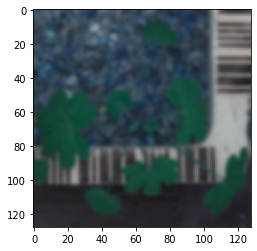

In [69]:
# Preview the image after Gaussian Blur
plt.imshow(X_train[10], cmap='gray')

In [70]:
# Gaussian Blue to Test and Validation sets
for idx, img in enumerate(X_test):
  X_test[idx] = cv2.GaussianBlur(img, (5, 5), 0)

for idx, img in enumerate(X_validation):
  X_validation[idx] = cv2.GaussianBlur(img, (5, 5), 0)

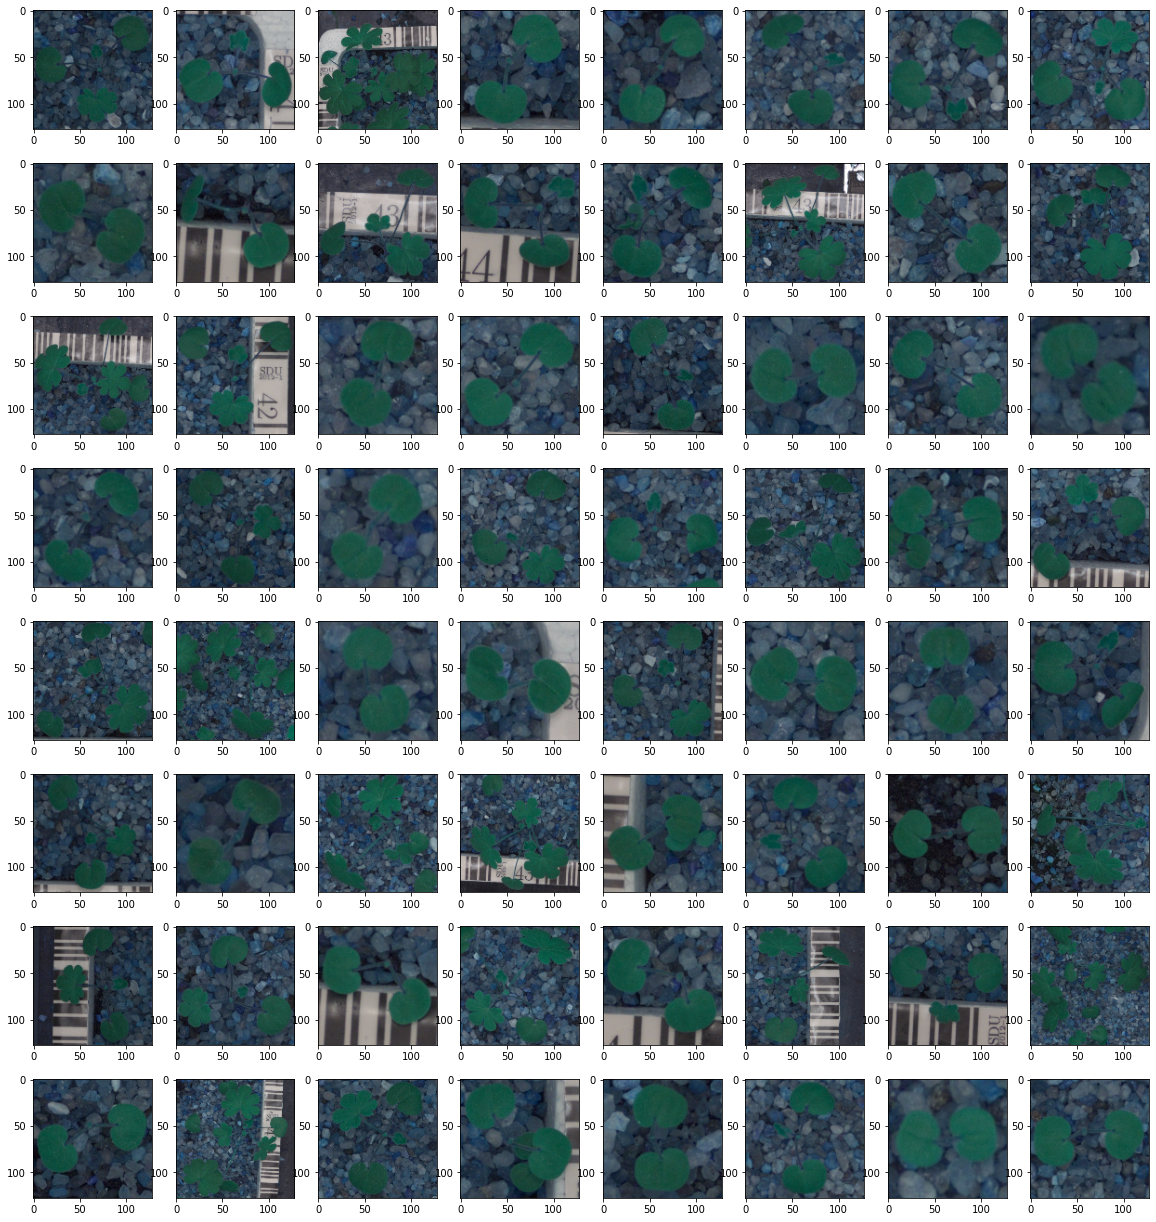

In [71]:
# visualize the images in dataset after pre-processing
fig=plt.figure(figsize=(20, 22))
columns = 8
rows = 8
for i in range(1, columns*rows +1):
    img = TrainImages[i]
    label = TrainLabels[i][0]
    #print(f'Image name:{label}')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show(block=True)

In [82]:
print(TrainImages.shape)
print(TrainImages.size)
print(TrainImages.ndim)
print(len(TrainImages))

(4750, 128, 128, 3)
233472000
4
4750


# Compatibility of input data with the Keras Model

You always have to give a 4D array as input to the CNN. So input data has a shape of (batch_size, height, width, depth), where the first dimension represents the batch size of the image and the other three dimensions represent dimensions of the image which are height, width, and depth. 
The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use.<br>
In our case we are training images with 4D model with the shape (4750, 128, 128, 3) for input and the output size which is 128x128. When the model is trained  with outputsize as 128x128, then the predicted size is also 128x128.

Check main_model.summary below, then you can see that output of main_model is (conv2d (Conv2D)              (None, 128, 128, 32))

As you can notice the output shape is ((None, 128, 128, 32). The first dimension represents the batch size, which is None at the moment. Because the network does not know the batch size in advance. Once you fit the data, None would be replaced by the batch size you give while fitting the data.
So our data is compatible with Keras model.

# CNN Model Architecture
The Sequential model is a linear stack of layers. The first layer in the model needs to receive information about its input shape and the following layers will do automatic shape reference. The convolutional layer is the core building block of a CNN. The layer's parameters consist of a set of learnable filters. During the forward pass, each filter is convolved across the image to produce a 2D activation map of each filter. Then stacking the activation maps for each filter forms the full output of the convolutional layer. The Batch normalization layer normalizes the activations of the convolutional layers by applying a transformation that maintains the mean close to 0 and the standard deviation close to 1. The max pooling layer serves as a form of non-linear downsampling. In this case, the 2x2 filters compute the maximum value of four pixels and make a stride of 2 pixels (width and height) at each depth. There are a total of 6 convolutional layers and 3 max pooling layers. The flatten layer is used to convert the final feature map into a 1D vector, combining all of the features of the previous layer. In the final layer, I used softmax activation so the neural network outputs the probability distribution for each class.

For the convolutional and dense layers, I used the ReLU activation function. For training deep neural networks, ReLU is more effective than the sigmoid and tangent activation functions because it prevents gradients from saturating. The vanishing gradient problem causes the neural network to get stuck preventing meaningful learning from taking place.

Before training the model, we need to configure the learning process by specifying the optimizer, loss function, and list of metrics. The loss function measures the error rate between the model's predicted and observed labels. The categorical crossentropy loss function is computed by taking the average of all cross-entropies in the sample. It will measure the probability that the training sample belongs to an individual class. The cost function is the average of the loss function over a large number of training samples. The goal of the optimization algorithm is to minimize the cost function by iteratively updating the weights and biases. I used the Adam (short for Adaptive Moment Estimation) optimizer because it's effective and achieves good results quickly. For information about how the optimizer works, click here.

## **Creating the Model**
Steps:

1. Initialize CNN Classifier

2. Add Convolution layer with 32 kernels of 3x3 shape

3. Add Maxpooling layer of size 2x2

4. Flatten the input array

5. Add dense layer with relu activation function

6. Dropout the probability

7. Add softmax Dense layer as output

In [83]:
def create_model(input_shape, num_classes):
  # Initialize CNN Classified
  model = Sequential()

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(32, (3,3), input_shape=input_shape, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Add convolution layer with 32 filters and 3 kernels
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(rate=0.25))

  # Flatten the 2D array to 1D array
  model.add(Flatten())

  # Create fully connected layers with 512 units
  model.add(Dense(512, activation=tf.nn.relu))
  model.add(Dropout(0.5))


  # Adding a fully connected layer with 128 neurons
  model.add(Dense(units = 128, activation = tf.nn.relu))
  model.add(Dropout(0.5))

  # The final output layer with 12 neurons to predict the categorical classifcation
  model.add(Dense(units = num_classes, activation = tf.nn.softmax))
  return model

**Sequential:**  Defines a Sequence of layers

**Conv2D:** Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.

**MaxPool2D:** The objective is to down-sample an input representation

**Flatten**: Convert the 2D to 1D array

**Dense:** Adds a layers of neurons

### **Activation Functions:**
**Relu:** Relu effectively means "If X>0 return X, else return 0" -- so what it does it it only passes values 0 or greater to the next layer in the network.

**Softmax:** takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it saves you from fishing through it looking for the biggest value, and turns it into [0,0,0,0,1,0,0,0,0] -- The goal is to save a lot of coding!

In [106]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=10)

In [85]:
input_shape = X_train.shape[1:] # Input shape of X_train
num_classes = y_train.shape[1] # Target column size

model = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer
# optimizer = tf.keras.optimizers.SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0

In [86]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=30, batch_size=100, callbacks=[callbacks])

Epoch 1/30
34/34 [==============================] - 2s 69ms/step - loss: 2.4457 - accuracy: 0.1332 - val_loss: 2.4442 - val_accuracy: 0.1346
Epoch 2/30
34/34 [==============================] - 2s 57ms/step - loss: 2.4026 - accuracy: 0.1603 - val_loss: 2.2702 - val_accuracy: 0.2482
Epoch 3/30
34/34 [==============================] - 2s 57ms/step - loss: 2.0422 - accuracy: 0.2995 - val_loss: 1.7100 - val_accuracy: 0.3815
Epoch 4/30
34/34 [==============================] - 2s 58ms/step - loss: 1.7438 - accuracy: 0.3789 - val_loss: 1.5132 - val_accuracy: 0.4923
Epoch 5/30
34/34 [==============================] - 2s 57ms/step - loss: 1.5711 - accuracy: 0.4644 - val_loss: 1.2258 - val_accuracy: 0.5891
Epoch 6/30
34/34 [==============================] - 2s 58ms/step - loss: 1.4009 - accuracy: 0.5170 - val_loss: 1.1746 - val_accuracy: 0.6241
Epoch 7/30
34/34 [==============================] - 2s 57ms/step - loss: 1.2577 - accuracy: 0.5684 - val_loss: 1.0696 - val_accuracy: 0.6606
Epoch 8/30
34

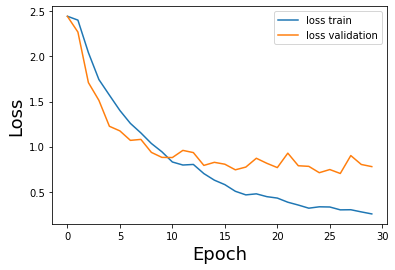

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('loss train','loss validation'), loc=0)

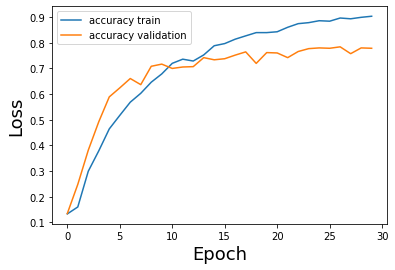

In [88]:
# Print accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel(r'Loss', fontsize=18)
plt.legend(('accuracy train','accuracy validation'), loc=0)

## **Model Evaluation**

In [89]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

23/23 [==============================] - 0s 10ms/step - loss: 0.7311 - accuracy: 0.8034
Test loss: 0.73 
 Test accuracy: 0.80
104/104 [==============================] - 1s 8ms/step - loss: 0.0902 - accuracy: 0.9672
Train loss: 0.09 
 Train accuracy: 0.97




**Model is overfitting since training accuracy is 97% and testing accuracy is 80%. let's stop it before 23 epoch**




# **Model Retrain**

In [151]:
model1 = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Optimizer

model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 32, 32, 64)       

In [152]:
history = model1.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=21, callbacks=[callbacks])

Epoch 1/21
104/104 [==============================] - 2s 24ms/step - loss: 2.4447 - accuracy: 0.1167 - val_loss: 2.4139 - val_accuracy: 0.1346
Epoch 2/21
104/104 [==============================] - 2s 21ms/step - loss: 2.3221 - accuracy: 0.2144 - val_loss: 1.8567 - val_accuracy: 0.3548
Epoch 3/21
104/104 [==============================] - 2s 21ms/step - loss: 1.8214 - accuracy: 0.3759 - val_loss: 1.4875 - val_accuracy: 0.5007
Epoch 4/21
104/104 [==============================] - 2s 21ms/step - loss: 1.5137 - accuracy: 0.4839 - val_loss: 1.1760 - val_accuracy: 0.6241
Epoch 5/21
104/104 [==============================] - 2s 22ms/step - loss: 1.2691 - accuracy: 0.5735 - val_loss: 1.0317 - val_accuracy: 0.6424
Epoch 6/21
104/104 [==============================] - 2s 22ms/step - loss: 1.0888 - accuracy: 0.6292 - val_loss: 0.9214 - val_accuracy: 0.6985
Epoch 7/21
104/104 [==============================] - 2s 22ms/step - loss: 0.9954 - accuracy: 0.6635 - val_loss: 0.8901 - val_accuracy: 0.7139

In [154]:
loss, accuracy = model1.evaluate(X_test, y_test)
print('Test loss: {:.2f} \n Test accuracy: {:.2f}'.format(loss, accuracy))

loss, accuracy = model1.evaluate(X_train, y_train)
print('Train loss: {:.2f} \n Train accuracy: {:.2f}'.format(loss, accuracy))

23/23 [==============================] - 0s 8ms/step - loss: 0.7113 - accuracy: 0.7767
Test loss: 0.71 
 Test accuracy: 0.78
104/104 [==============================] - 1s 8ms/step - loss: 0.1437 - accuracy: 0.9405
Train loss: 0.14 
 Train accuracy: 0.94


**The early stopping helping model to balance accuracy b/w test and training. Let's save the mode for future re-training**

In [122]:
from keras.models import load_model
model1.save(save_extracted+'final_model.h5')

In [123]:
model1.load_weights(save_extracted+'final_model.h5')

# **Confusion matrix**

In [135]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) 

In [136]:
y_pred1 = model1.predict(X_test)
y_pred1 = (y_pred1 > 0.5) 

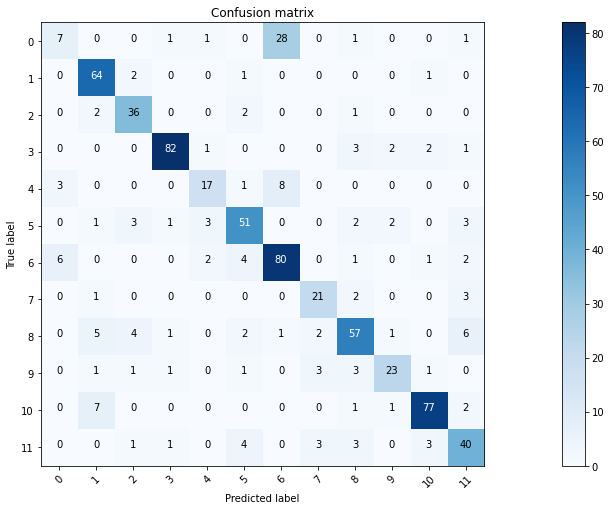

In [156]:
# Confusion Matrix for initial Model 
plt.subplots(figsize=(22,7)) #set the size of the plot 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validation,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(12))

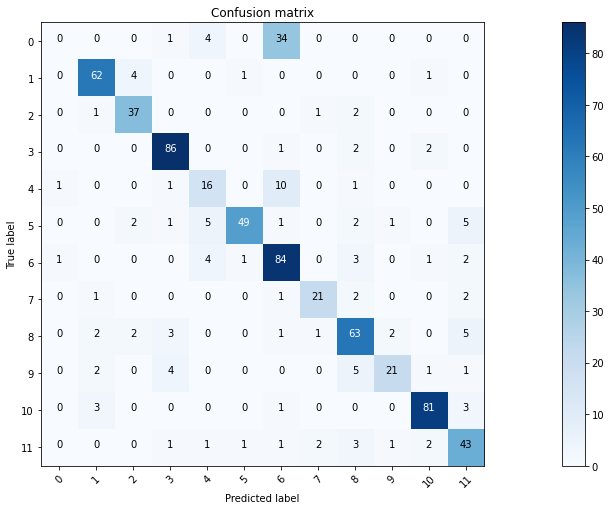

In [155]:
# Confusion Matrix for final Model1 
plt.subplots(figsize=(22,7)) #set the size of the plot 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model1.predict(X_validation)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validation,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(12))

# **Visualize predictions**
for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59].

Predicted label: Loose Silky-bent


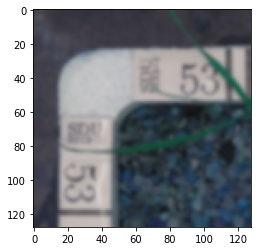

In [159]:
y_pred1 = encoder.inverse_transform(y_pred1)

index = 2
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred1[index])

Predicted label: Common Chickweed


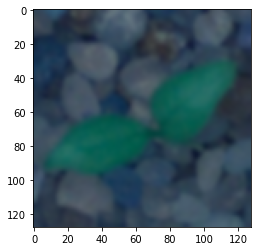

In [160]:
index = 3
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred1[index])

Predicted label: Black-grass


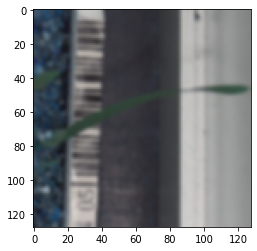

In [161]:
index = 33
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred1[index])

Predicted label: Black-grass


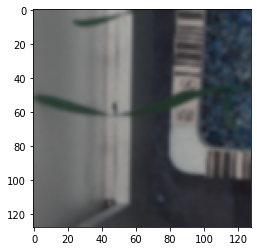

In [162]:
index = 36
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred1[index])

Predicted label: Small-flowered Cranesbill


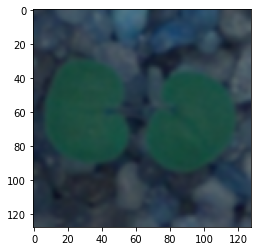

In [163]:
index = 59
plt.imshow(X_test[index], cmap='gray')
print("Predicted label:", y_pred1[index])